# Assignment #8

This assignment can be completed by adding code to this notebook for each question.

Turn in a completed script, renamed as

`assignment8_<username>.py`

with your `<username>` being your DataVU login name (e.g., mine is `kgoebber`) to `/archive/courses/met330/assignment8` via the Linux computing system.

**DUE DATE: 18 November 2022 at 5 pm.**

Prior to turning in your script, please cleanup and comment your code for each problem. Be sure that your output is self-describing.

In [ ]:
# add all imports needed to this cell
from datetime import datetime, timedelta


## Question #1
(25 points) Create a gridded interpolation of MSLP for a given date and time with a five minute timedelta. Plot a region for the eastern CONUS (from Colorado to just off the Atlantic coast) including the contours of MSLP (every 4 hPa) from the gridded interpolation and the MSLP values to the tenths (e.g., 1004.3 hPa).

Data (5 points):
  * Use ASOS surface observations using given definition to read data using a 5 minute timedelta
  * Use altimeter values (`alti`) and convert to units of `hPa` from `inHg`

Grid Interpolation (10 points):
  * interpolation type: `'rbf'`
  * horizontal grid spacing: `0.25` degree lat/lon
  * smooth contour field

Plot Grid and Observations (10 points):
  * Region: west=-110 W; east=-60 W; south=25 N; north=50 N
  * Use a Lambert Conformal Projection with `central_longitude=-100` and `central_latitude=40`
  * Contours of MSLP (every 4 hPa) from gridded interpolation of surface observations
  * Plot values of MSLP in tenths (e.g., 1003.4 hPa)
  * Reduce plotted values with radius of 100 km (https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.reduce_point_density.html)
  
Example Image:
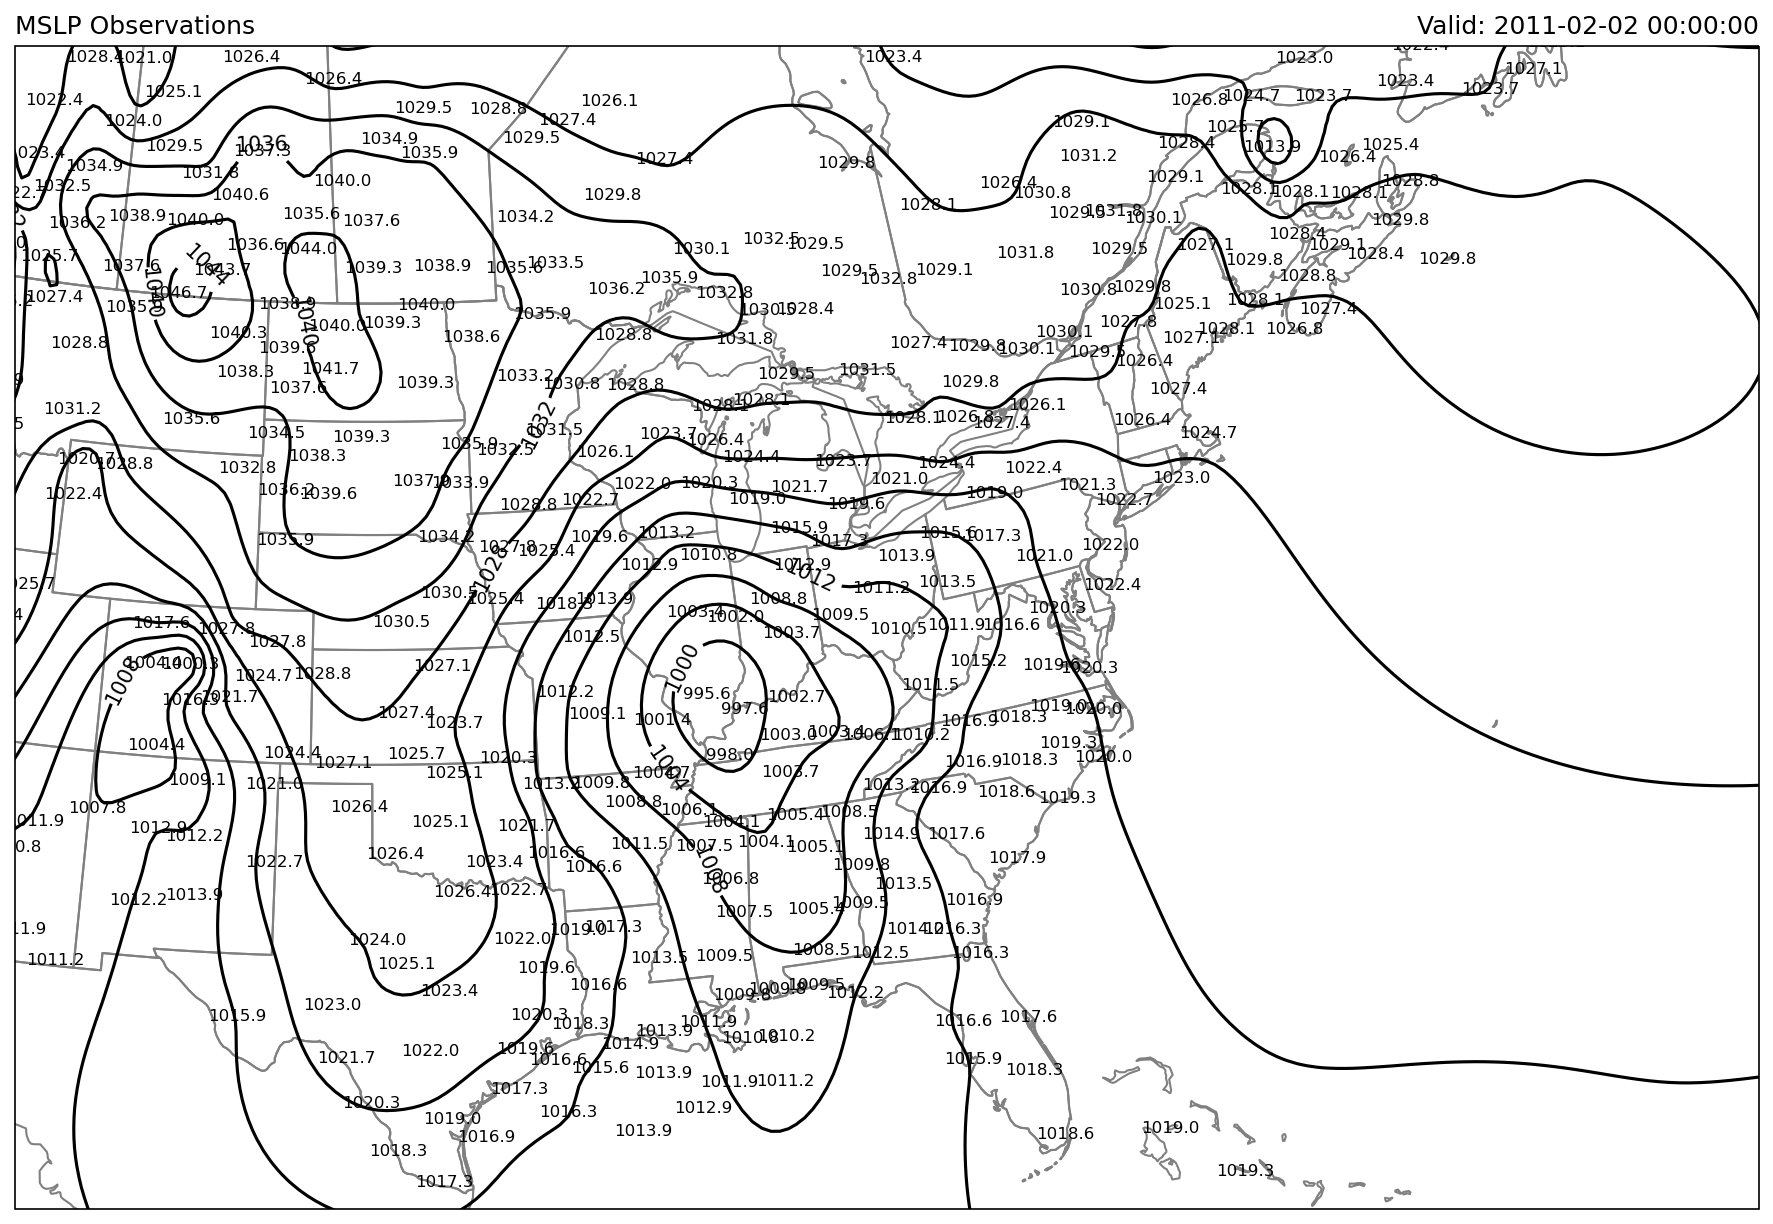

In [ ]:
def read_remote_surface_data(date, dt=timedelta(minutes=20)):
    '''A function to read data from Iowa State ASOS archive.
    
    Input:
      - date: a datetime object
      - dt: a timedelta object indicating the timespan to collect data
    
    Output:
      - returns a Pandas DataFrame of the most recent surface observations from the given date, time, and timedelta range.
    '''
    import pandas as pd
    
    sdate = date - dt
    edate = date + dt

    df = pd.read_csv('http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?data=all&tz=Etc/UTC&format=comma&latlon=yes&'
                     f'year1={sdate.year}&month1={sdate.month}&day1={sdate.day}&hour1={sdate.hour}&minute1={sdate.minute}&'
                     f'year2={edate.year}&month2={edate.month}&day2={edate.day}&hour2={edate.hour}&minute2={edate.minute}',
                     skiprows=5, na_values=['M']).replace('T', 0.00001)
    return df.groupby('station').tail(1)

## Question #2

(35 points) Construct an RGB Airmass product for GOES-16 for a chosen date and time (where the time should be one of 00, 06, 12, or 18 UTC) and compute and plot the GFS 303 K isentropic surface (pressure and wind components) over a CONUS domain as an overlay on the computed RGB Airmass image.

The RGB Airmass product is a combination of four different infrared bands. It is useful for identifying air masses, monitoring jet streams and jet streaks, cyclogenesis and potential vorticity maxima or anomalies.
 - The 'Red' channel is a difference of ABI bands 8 and 10
 - The 'Green' is a difference of bands 12 and 13
 - The 'Blue' is solely being represented by ABI band 8 (convert to Celsius from Kelvin).

Convert Channel to values between 0 and 1 with:
`channel = ((channel - min_val) / (max_val - min_val))**(1 / gamma)`

## Airmass RGB Recipe
Color | Band / Band Diff. (μm) | Min – Max | Gamma
-|-|-|-
Red | 6.2 – 7.3 | -26.2 to 0.6 C | 1
Green | 9.6 – 10.3 | -43.2 to 6.7 C | 1
Blue | 6.2 | -29.25 to -64.65 C | 1

Question Elements:
* Read required ABI bands 8, 10, 12, and 13 (5 points)
  - Use the function given below to read each channel and isolate the `Sectorized_CMI` variable
* Compute RGB Airmass imagery (10 points)
* Compute the GFS 303 K isentropic surface (5 points)
  - Use the following data access for recent GFS, which uses a datetime object stored as `date`
```python
  ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/'
                      f'Global_0p5deg/GFS_Global_0p5deg_{date:%Y%m%d_%H}00.grib2')
```
* Plot the RGB Airmass imagery (5 points)
* Plot the 300 K isentropic pressure and wind barbs as an overlay (10 points)

Example Image:
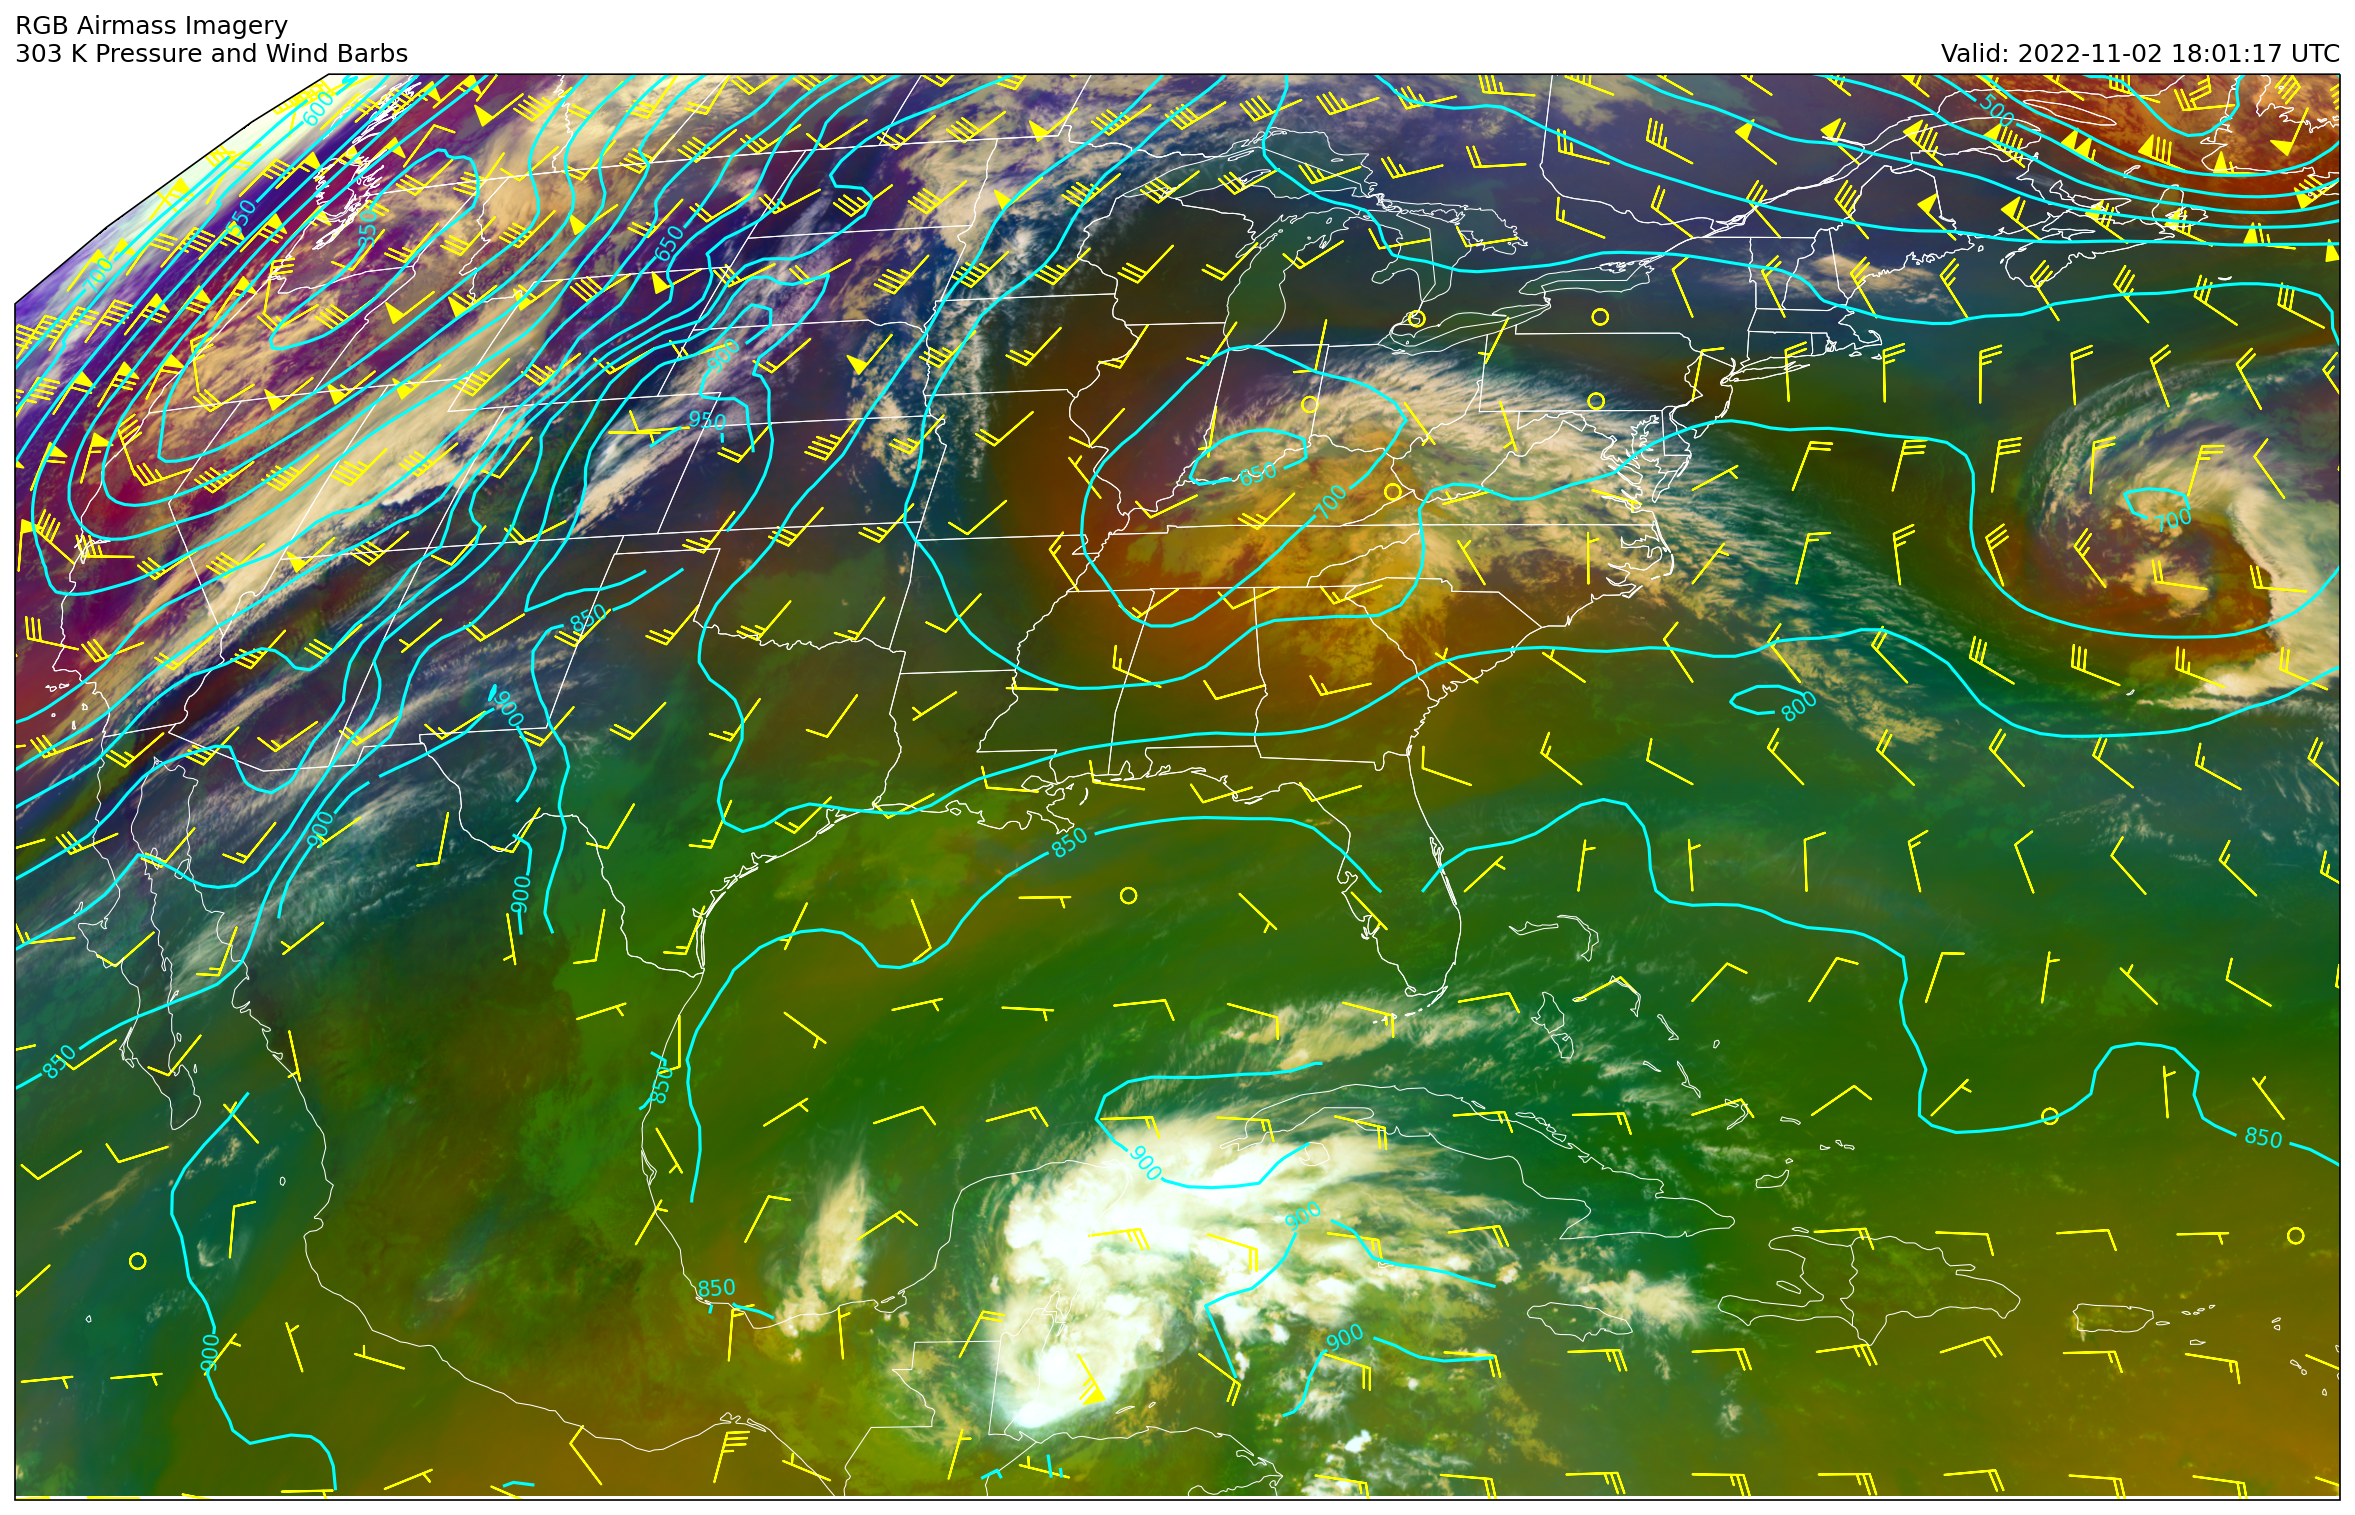

In [ ]:
def get_satellite_data(date, region='CONUS', channel=2, satellite='east'):
    '''
    This function helps to obtain GOES satellite data by channel from the UCAR THREDDS server.
    
    Input:
      * date - a datetime object specifying the desired time
      * region - the portion of satellite data wanted
        - CONUS (default)
        - fulldisk
      * channel (int value 1 - 16; default is 2)
      * satellite ('east' or 'west'; default is 'east')
    
    Output:
      * xarray DataArray containing the nearest time requested satellite data for the region, channel, and satellite.
    '''
    # We want to match something like:
    # https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

    # Construct the data_url string
    data_url = (f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/{satellite}/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
                f'{date:%Y%m%d}/catalog.xml')

    # Get list of files available for particular day
    cat = TDSCatalog(data_url)

    # Grab dataset for desired time
    dataset = cat.datasets.filter_time_nearest(date, regex=r'_s(?P<strptime>\d{13})', strptime='%Y%j%H%M%S')

    # Open most recent file available
    ds = dataset.remote_access(use_xarray=True).metpy.parse_cf()
    
    return ds